In [1]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import re
from nltk.corpus import stopwords
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk import FreqDist
import spacy
from string import punctuation

In [7]:
stop_words = set(stopwords.words('english'))

# Use whole narratives to find how company response to consumer

In [2]:
df = pd.read_csv('D:/narratives.csv')

In [4]:
df.head()

,Unnamed: 0,Date.received,Product,Sub.product,Issue,Sub.issue,Consumer.complaint.narrative,Company.public.response,Company,State,ZIP.code,Tags,Consumer.consent.provided.,Submitted.via,Date.sent.to.company,Company.response.to.consumer,Timely.response.,Consumer.disputed.,Complaint.ID
0,1,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \r\nis trying to colle...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3384392
1,3,2019-10-25,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,I would like to request the suppression of the...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,937XX,NaN,Consent provided,Web,2019-10-25,Closed with explanation,Yes,NaN,3417821
2,4,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX,NaN,Consent provided,Web,2019-11-08,Closed with explanation,Yes,NaN,3433198
3,11,2019-09-08,"Money transfer, virtual currency, or money ser...",Domestic (US) money transfer,Fraud or scam,NaN,"I was sold access to an event digitally, of wh...",NaN,"Paypal Holdings, Inc",RI,029XX,NaN,Consent provided,Web,2019-09-08,Closed with explanation,Yes,NaN,3366475
4,12,2019-09-24,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,While checking my credit report I noticed thre...,Company has responded to the consumer and the ...,"HCFS Health Care Financial Services, Inc.",FL,333XX,NaN,Consent provided,Web,2019-09-24,Closed with explanation,Yes,NaN,3385399


In [5]:
df.shape

(487582, 19)

In [6]:
#clean the column names
lis = []
for name in df.columns:
    name = re.sub('[^a-zA-Z0-9]+', "_", name)
    lis.append(name)
    
df.columns = lis

In [7]:
df_close = df[df['Company_response_to_consumer'].notna()]

In [8]:
df_close.shape

(487581, 19)

In [9]:
df_sample, df_drop_it = train_test_split(df_close, train_size =0.1, stratify=df_close['Company_response_to_consumer'])

In [10]:
df_sample.shape

(48758, 19)

In [11]:
df_clean = pd.DataFrame()

for x in df_sample.Consumer_complaint_narrative:
    x_clean = re.sub('[^a-zA-Z]+', ' ', x)
    x_clean = re.sub('XXXX', '', x_clean)
    x_clean = re.sub('XX/XX', "", x_clean)
    x_clean = re.sub('XX/XX/', "", x_clean)
    x_clean = re.sub('XXX', "", x_clean)
    x_clean = re.sub('XX', "", x_clean)
    text = [word.lower() for word in x_clean.split()]
    text = [word for word in text if word not in stop_words]
    long_words=[]
    for i in text:
        if len(i)>1:                    
            long_words.append(i)   
    text = [my_stem.lemmatize(word) for word in long_words]
    join = " ".join(text)
    df_clean = df_clean.append({"body_stem" : text, "body" : join}, ignore_index=True)

In [12]:
df_clean.shape

(48758, 2)

In [13]:
df_clean['Company_response_to_consumer'] = list(df_sample.Company_response_to_consumer)

In [14]:
df_clean.head()

,body,body_stem,Company_response_to_consumer
0,mid valley collection bureau mvcb formerly bus...,"[mid, valley, collection, bureau, mvcb, former...",Closed with explanation
1,judge dismissed case twice debt collector hara...,"[judge, dismissed, case, twice, debt, collecto...",Closed with explanation
2,account type installment loan account number d...,"[account, type, installment, loan, account, nu...",Closed with explanation
3,submitted dispute equifax bankruptcy public re...,"[submitted, dispute, equifax, bankruptcy, publ...",Closed with explanation
4,company list went forclosure never borrowed mo...,"[company, list, went, forclosure, never, borro...",Closed with explanation


### LDA

In [25]:
unique_labels = set(df_clean.Company_response_to_consumer)
the_topic_dict = dict()

for label in unique_labels:
    id2word = corpora.Dictionary(df_clean.body_stem[df_clean.Company_response_to_consumer == label])
    corpus = [id2word.doc2bow(text) for text in df_clean.body_stem[df_clean.Company_response_to_consumer == label]]
    
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=1,
                                                       id2word=id2word,
                                                       random_state=100,
                                                       update_every=1,
                                                       chunksize=100,
                                                       passes=10,
                                                       alpha='auto',
                                                       per_word_topics=True)
    topics = ldamodel.print_topics(num_words=10)
            
    the_topic_dict[label] = topics
        
the_topic_dict

{'Closed': [(0,
   '0.015*"account" + 0.014*"credit" + 0.011*"debt" + 0.009*"payment" + 0.008*"collection" + 0.008*"bank" + 0.008*"loan" + 0.008*"would" + 0.007*"company" + 0.007*"call"')],
 'Closed with non-monetary relief': [(0,
   '0.027*"credit" + 0.024*"account" + 0.016*"report" + 0.010*"payment" + 0.009*"information" + 0.007*"reporting" + 0.007*"debt" + 0.007*"time" + 0.006*"would" + 0.006*"company"')],
 'Untimely response': [(0,
   '0.013*"debt" + 0.012*"call" + 0.012*"account" + 0.011*"company" + 0.009*"credit" + 0.009*"loan" + 0.009*"would" + 0.008*"payment" + 0.008*"phone" + 0.008*"number"')],
 'Closed with monetary relief': [(0,
   '0.021*"account" + 0.014*"bank" + 0.012*"payment" + 0.012*"fee" + 0.012*"card" + 0.011*"would" + 0.011*"credit" + 0.009*"told" + 0.008*"time" + 0.008*"charge"')],
 'Closed with explanation': [(0,
   '0.018*"credit" + 0.018*"account" + 0.013*"payment" + 0.010*"loan" + 0.009*"report" + 0.008*"information" + 0.008*"would" + 0.008*"debt" + 0.007*"time

# Overview data

In [4]:
df = pd.read_csv('D:/complaints.csv')

In [5]:
df.columns

Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

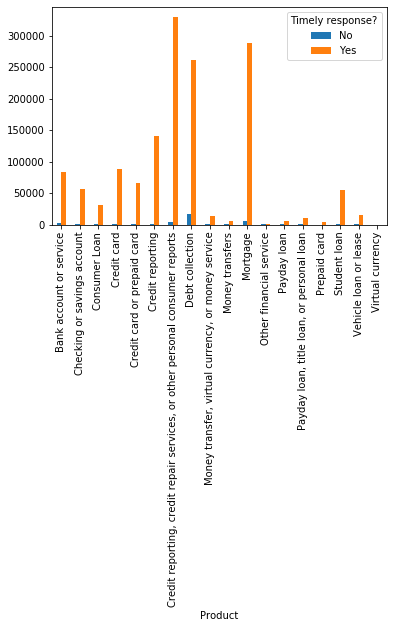

In [7]:
pd.crosstab(df['Product'],df['Timely response?']).plot(kind='bar')

# Text summerization

In [3]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [11]:
def summarizer(text, percentage):
    doc = nlp(text)
    word_frequencies = {}
    for word in doc:
        if word.text.lower() not in stop_words:
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
                    
    max_frequency = max(word_frequencies.values())              
    for word in word_frequencies.keys():
        word_frequencies[word] = word_frequencies[word]/max_frequency
    
    sentence_tokens = [sent for sent in doc.sents]
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():
                    sentence_scores[sent] = word_frequencies[word.text.lower()]
                else:
                    sentence_scores[sent] += word_frequencies[word.text.lower()]
    from heapq import nlargest
    select_length = int(len(sentence_tokens)*percentage)
    if select_length < 1:
        summary = nlargest(1, sentence_scores, key = sentence_scores.get)
        final_summary = [word.text for word in summary]
        summary = ' '.join(final_summary)
    else:
        summary = nlargest(select_length, sentence_scores, key = sentence_scores.get)
        final_summary = [word.text for word in summary]
        summary = ' '.join(final_summary)
    
    return summary

In [12]:
df = pd.read_csv('D:/loan_nar.csv')
#clean the column names
lis = []
for name in df.columns:
    name = re.sub('[^a-zA-Z0-9]+', "_", name)
    lis.append(name)
    
df.columns = lis

In [13]:
#Can be very effective to identify subissue
x = df.Consumer_complaint_narrative[4]
y = summarizer(x, 0.3)
print('original text: ', x)
print('summarized text: ', y)

original text:  XXXX is reporting incorrectly to Equifax and XXXX an account balance of {$2300.00} on the XXXX partial account number XXXX. ( Please see pages 12 and 13 of the attached credit report ). This account is over 7 years old and therefore should not be on my credit report. This incorrect reporting is harming my credit score and is a Fair Credit Reporting Act ( F.C.R.A. ) violation.
summarized text:  This incorrect reporting is harming my credit score and is a Fair Credit Reporting Act ( F.C.R.A. ) violation.


In [14]:
x = df.Consumer_complaint_narrative[19]
y = summarizer(x, 0.3)
print('original text: ', x)
print('summarized text: ', y)

original text:  XXXX ; XXXX and Transunion are reporting incorrectly that I am ( 60 ) days late on the XXXX XXXX account number XXXX. ( Please see page attached from my credit report. ) This account reports a {$0.00} balance and {$0.00} past due. Please keep in mind that it is impossible to be late on an account that has a {$0.00} balance and {$0.00} past due. This incorrect reporting is harming my credit score and these line items need to be removed from my credit report. I have contacted the ( 3 ) bureaus to fix this however, I have not been successful.
summarized text:  Please keep in mind that it is impossible to be late on an account that has a {$0.00} balance and {$0.00} past due.


In [16]:
x = df.Consumer_complaint_narrative[244]
y = summarizer(x, 0.5)
print('original text: ', x)
print('summarized text: ', y)

original text:  I am very concerned about the validity and accuracy of the recent investigation done by Equifax. I requested for an investigation because the accounts have nothing to do with me. I am a victim of identity theft and the accounts are not my responsibility. Equifax failed to give me the result of their investigation. I assume they were unable to verify it. The error has affected my credit score tremendously. CFPB please step up and delete this ASAP, this is very exhausting, nobody wants to grant me a loan because of this. 

XXXX XXXX XXXX XXXX XXXX
summarized text:  I am very concerned about the validity and accuracy of the recent investigation done by Equifax. I requested for an investigation because the accounts have nothing to do with me. Equifax failed to give me the result of their investigation. I am a victim of identity theft and the accounts are not my responsibility.
